In [4]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time

# Step 1: Train a classification model on MNIST with at least one hidden layer

#### prepare MNIST

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Flatten and scale to [0,1]
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 28*28).astype("float32") / 255.0

input_dim = x_train.shape[1]  # 784
num_classes = 10
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(60000, 784) (60000,) (10000, 784) (10000,)


# Simple baseline model

In [3]:
model = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train, y_train,
                    epochs=5, batch_size=128,
                    validation_split=0.1, verbose=0)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Baseline — Test accuracy:", round(float(test_acc), 4))

Baseline — Test accuracy: 0.9711


# Step 2: Experiment with 2–3 activation functions

#### I try different hidden activations

In [5]:
activations = ["relu", "sigmoid", "tanh"]
act_results = []

for act in activations:
    m = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128, activation=act),
        keras.layers.Dense(num_classes, activation="softmax")
    ])
    m.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    t0 = time.perf_counter()
    m.fit(x_train, y_train, epochs=5, batch_size=128,
          validation_split=0.1, verbose=0)
    train_time = time.perf_counter() - t0
    test_acc = m.evaluate(x_test, y_test, verbose=0)[1]
    act_results.append((act, round(train_time, 2), round(float(test_acc), 4)))

print("\n=== Step 3: Hidden activations ===")
for act, t, acc in act_results:
    print(f"activation={act:7s} | time(s)={t:6.2f} | test_acc={acc:.4f}")



=== Step 3: Hidden activations ===
activation=relu    | time(s)= 49.71 | test_acc=0.9691
activation=sigmoid | time(s)= 53.89 | test_acc=0.9520
activation=tanh    | time(s)= 53.89 | test_acc=0.9669


# Step 3: compare result across optimizera and document accurcy difference 

In [6]:
input_dim = 28 * 28
num_classes = 10

def build_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model

- Train with Adam

In [7]:
model_adam = build_model()
model_adam.compile(optimizer="adam",
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])
start = time.perf_counter()
model_adam.fit(x_train, y_train, epochs=5, batch_size=128,
               validation_split=0.1, verbose=0)
adam_time = time.perf_counter() - start
adam_acc = model_adam.evaluate(x_test, y_test, verbose=0)[1]
print(f"ADAM     -> time(s) = {adam_time:.2f} | test_acc = {adam_acc:.4f}")

ADAM     -> time(s) = 49.89 | test_acc = 0.9698


- Train with SGd

In [9]:
model_sgd = build_model()
model_sgd.compile(optimizer="sgd",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
start = time.perf_counter()
model_sgd.fit(x_train, y_train, epochs=5, batch_size=128,
              validation_split=0.1, verbose=0)
sgd_time = time.perf_counter() - start
sgd_acc = model_sgd.evaluate(x_test, y_test, verbose=0)[1]
print(f"SGD      -> time(s) = {sgd_time:.2f} | test_acc = {sgd_acc:.4f}")

SGD      -> time(s) = 27.02 | test_acc = 0.9058


- Train with RMSprop

In [11]:
model_rms = build_model()
model_rms.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
start = time.perf_counter()
model_rms.fit(x_train, y_train, epochs=5, batch_size=128,
              validation_split=0.1, verbose=0)
rms_time = time.perf_counter() - start
rms_acc = model_rms.evaluate(x_test, y_test, verbose=0)[1]
print(f"RMSprop  -> time(s) = {rms_time:.2f} | test_acc = {rms_acc:.4f}")

RMSprop  -> time(s) = 53.74 | test_acc = 0.9720


- Just to check the best accurcy we will do simple decumentation 

In [20]:
best_acc = adam_acc
best_name = "adam"
if sgd_acc > best_acc:
    best_acc = sgd_acc
    best_name = "sgd"
if rms_acc > best_acc:
    best_acc = rms_acc
    best_name = "RMSprop"
    
print("\n--- Accuracy summary ---")
print(f"Best accuracy is with: {best_name} (acc = {best_acc:.4f})")
print(f"adam    diff vs best: {adam_acc - best_acc:+.4f}")
print(f"sgd     diff vs best: {sgd_acc - best_acc:+.4f}")
print(f"RMSprop diff vs best: {rms_acc - best_acc:+.4f}")


--- Accuracy summary ---
Best accuracy is with: RMSprop (acc = 0.9720)
adam    diff vs best: -0.0022
sgd     diff vs best: -0.0662
RMSprop diff vs best: +0.0000


# Plot training & validation accuracy

In [17]:
import matplotlib.pyplot as plt

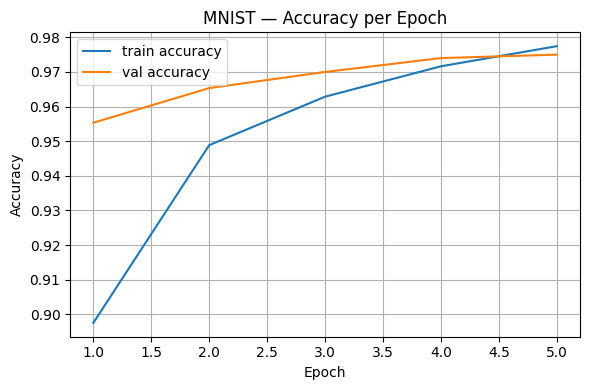

In [18]:
epochs_range = range(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_range, history.history["accuracy"], label="train accuracy")
plt.plot(epochs_range, history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MNIST — Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()